In [1]:
import sys
sys.path.append("..") 
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
input_len, output_len = 20, 10 

In [4]:
data = pd.read_csv('../flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split, scaler = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                        features=select_features, covariates=False)
# features = getFeatures()

['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']


In [5]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 20, 7])
torch.Size([64, 10])


In [6]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)
        outputs = []
        for _ in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            output = self.fc(output) 
            outputs.append(output[:, :, -1].unsqueeze(2))
            x = output

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, output_len, lstm_num_hidden, num_layers)

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        h, c = self.encoder(x)
        xt = x[:, -1, :].unsqueeze(1) # input the last time step of x into the decoder
        outputs = self.decoder(xt, h, c) # (batch_size, output_len, 1)
        return outputs

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(select_features)
hidden_size = 32  
num_layers = 1


# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_len, output_len, [16, 32], hidden_size, num_layers=num_layers).to(device)

cuda


In [8]:
# get the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters')

The model has 11,228 trainable parameters


In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)
        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_layers=1, covariate=False, covariate_size=0):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        if covariate:
            self.fc = nn.Linear(hidden_size+covariate_size, input_size)
        else:
            self.fc = nn.Linear(hidden_size, input_size)
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.covariate = covariate

    def forward(self, xt, hidden, cell, covariates=None):
        # repeat the hidden states according to the number of layers
        h = hidden.repeat(self.num_layers, 1, 1)
        c = cell.repeat(self.num_layers, 1, 1)

        outputs = []
        for t in range(self.seq_len):
            output, (h, c) = self.lstm(xt, (h, c))
            if self.covariate:
                output = torch.cat((output, covariates[:, t, :].unsqueeze(1)), dim=2)
            output = self.fc(output)
            outputs.append(output[:, :, -1].unsqueeze(2))
            xt = output  # use the decoder output as the next input

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, encoder_input_size, decoder_input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, 
                 tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1, covariate=False, covariate_size=0):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(encoder_input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(decoder_input_size, output_len, lstm_num_hidden, num_layers, covariate, covariate_size)
        self.decoder_input_size = decoder_input_size

    def forward(self, historic_inputs, covariates=None):
        """
        By default, the last feature of the encoder input is the target feature.
        And the decoder_input = encoder_input[-decoder_input_size:]
        """
        # x: (batch_size, input_len, input_size)
        h, c = self.encoder(historic_inputs)
        xt = historic_inputs[:, -1, -self.decoder_input_size:].unsqueeze(1)
        if self.decoder_input_size == 1:
            xt = xt.unsqueeze(2)
        outputs = self.decoder(xt, h, c, covariates) # (batch_size, output_len, 1)
        return outputs

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(select_features)
hidden_size = 32  
num_layers = 1


# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_size, input_len, output_len, [32, 32], hidden_size, num_layers=num_layers).to(device)

cuda


In [11]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 25
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        with torch.no_grad():
            outputs = seq2seq(inputs)  
            outputs = outputs.squeeze(-1) # (batch_size, output_len)
            loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_select2_best_model_{input_len}-{output_len}.pt')


Epoch 1/25 [TRAIN]: 100%|██████████| 2296/2296 [00:50<00:00, 45.90it/s, train_loss=0.0116] 


Epoch 1/25, Average Training Loss: 0.006532


Epoch 1/25 [VAL]: 100%|██████████| 769/769 [00:08<00:00, 88.91it/s, val_loss=0.00488]


Epoch 1/25, Average Validation Loss: 0.004340


Epoch 2/25 [TRAIN]: 100%|██████████| 2296/2296 [00:37<00:00, 60.88it/s, train_loss=0.0031] 


Epoch 2/25, Average Training Loss: 0.003979


Epoch 2/25 [VAL]: 100%|██████████| 769/769 [00:09<00:00, 82.05it/s, val_loss=0.00604]


Epoch 2/25, Average Validation Loss: 0.004367


Epoch 3/25 [TRAIN]: 100%|██████████| 2296/2296 [00:39<00:00, 57.81it/s, train_loss=0.00578]


Epoch 3/25, Average Training Loss: 0.003716


Epoch 3/25 [VAL]: 100%|██████████| 769/769 [00:09<00:00, 79.43it/s, val_loss=0.00723]


Epoch 3/25, Average Validation Loss: 0.004902


Epoch 4/25 [TRAIN]: 100%|██████████| 2296/2296 [00:39<00:00, 58.18it/s, train_loss=0.00744]


Epoch 4/25, Average Training Loss: 0.003577


Epoch 4/25 [VAL]: 100%|██████████| 769/769 [00:08<00:00, 89.19it/s, val_loss=0.00478]


Epoch 4/25, Average Validation Loss: 0.003456


Epoch 5/25 [TRAIN]: 100%|██████████| 2296/2296 [00:38<00:00, 59.39it/s, train_loss=1.15e-6]


Epoch 5/25, Average Training Loss: 0.003431


Epoch 5/25 [VAL]: 100%|██████████| 769/769 [00:09<00:00, 83.82it/s, val_loss=0.00399]


Epoch 5/25, Average Validation Loss: 0.003214


Epoch 6/25 [TRAIN]: 100%|██████████| 2296/2296 [00:39<00:00, 58.68it/s, train_loss=0.00284]


Epoch 6/25, Average Training Loss: 0.003335


Epoch 6/25 [VAL]: 100%|██████████| 769/769 [00:09<00:00, 83.51it/s, val_loss=0.0038] 


Epoch 6/25, Average Validation Loss: 0.003480


Epoch 7/25 [TRAIN]: 100%|██████████| 2296/2296 [00:39<00:00, 57.94it/s, train_loss=0.00311]


Epoch 7/25, Average Training Loss: 0.003276


Epoch 7/25 [VAL]: 100%|██████████| 769/769 [00:08<00:00, 93.70it/s, val_loss=0.00433] 


Epoch 7/25, Average Validation Loss: 0.003135


Epoch 8/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 73.59it/s, train_loss=0.000254]


Epoch 8/25, Average Training Loss: 0.003190


Epoch 8/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 115.45it/s, val_loss=0.0044] 


Epoch 8/25, Average Validation Loss: 0.003066


Epoch 9/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 72.48it/s, train_loss=1.47e-5]


Epoch 9/25, Average Training Loss: 0.003145


Epoch 9/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 99.83it/s, val_loss=0.0041]  


Epoch 9/25, Average Validation Loss: 0.003045


Epoch 10/25 [TRAIN]: 100%|██████████| 2296/2296 [00:32<00:00, 71.72it/s, train_loss=0.000417]


Epoch 10/25, Average Training Loss: 0.003101


Epoch 10/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 106.45it/s, val_loss=0.00377]


Epoch 10/25, Average Validation Loss: 0.003232


Epoch 11/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 72.43it/s, train_loss=0.00327]


Epoch 11/25, Average Training Loss: 0.003041


Epoch 11/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 110.62it/s, val_loss=0.00408]


Epoch 11/25, Average Validation Loss: 0.003018


Epoch 12/25 [TRAIN]: 100%|██████████| 2296/2296 [00:33<00:00, 69.36it/s, train_loss=0.00126]


Epoch 12/25, Average Training Loss: 0.003008


Epoch 12/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 107.35it/s, val_loss=0.00403]


Epoch 12/25, Average Validation Loss: 0.002962


Epoch 13/25 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 76.53it/s, train_loss=0.000741]


Epoch 13/25, Average Training Loss: 0.002977


Epoch 13/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 118.63it/s, val_loss=0.00447]


Epoch 13/25, Average Validation Loss: 0.002853


Epoch 14/25 [TRAIN]: 100%|██████████| 2296/2296 [00:29<00:00, 78.98it/s, train_loss=0.0217] 


Epoch 14/25, Average Training Loss: 0.002948


Epoch 14/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 110.93it/s, val_loss=0.00568]


Epoch 14/25, Average Validation Loss: 0.003421


Epoch 15/25 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 76.06it/s, train_loss=0.00421]


Epoch 15/25, Average Training Loss: 0.002942


Epoch 15/25 [VAL]: 100%|██████████| 769/769 [00:08<00:00, 95.74it/s, val_loss=0.00424] 


Epoch 15/25, Average Validation Loss: 0.002839


Epoch 16/25 [TRAIN]: 100%|██████████| 2296/2296 [00:33<00:00, 69.53it/s, train_loss=0.000724]


Epoch 16/25, Average Training Loss: 0.002880


Epoch 16/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 106.98it/s, val_loss=0.00387]


Epoch 16/25, Average Validation Loss: 0.002821


Epoch 17/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 73.83it/s, train_loss=0.0016] 


Epoch 17/25, Average Training Loss: 0.002872


Epoch 17/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 100.69it/s, val_loss=0.00433]


Epoch 17/25, Average Validation Loss: 0.002792


Epoch 18/25 [TRAIN]: 100%|██████████| 2296/2296 [00:32<00:00, 71.68it/s, train_loss=0.00516]


Epoch 18/25, Average Training Loss: 0.002831


Epoch 18/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.70it/s, val_loss=0.00432]


Epoch 18/25, Average Validation Loss: 0.002847


Epoch 19/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 71.75it/s, train_loss=3.37e-5]


Epoch 19/25, Average Training Loss: 0.002817


Epoch 19/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 102.94it/s, val_loss=0.0042] 


Epoch 19/25, Average Validation Loss: 0.002744


Epoch 20/25 [TRAIN]: 100%|██████████| 2296/2296 [00:32<00:00, 71.54it/s, train_loss=0.00314]


Epoch 20/25, Average Training Loss: 0.002812


Epoch 20/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 102.95it/s, val_loss=0.00419]


Epoch 20/25, Average Validation Loss: 0.002782


Epoch 21/25 [TRAIN]: 100%|██████████| 2296/2296 [00:32<00:00, 70.33it/s, train_loss=0.000821]


Epoch 21/25, Average Training Loss: 0.002779


Epoch 21/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 104.27it/s, val_loss=0.00413]


Epoch 21/25, Average Validation Loss: 0.002768


Epoch 22/25 [TRAIN]: 100%|██████████| 2296/2296 [00:32<00:00, 71.21it/s, train_loss=0.00625]


Epoch 22/25, Average Training Loss: 0.002768


Epoch 22/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 115.11it/s, val_loss=0.00398]


Epoch 22/25, Average Validation Loss: 0.002782


Epoch 23/25 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 76.02it/s, train_loss=0.000436]


Epoch 23/25, Average Training Loss: 0.002751


Epoch 23/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.42it/s, val_loss=0.00399]


Epoch 23/25, Average Validation Loss: 0.002833


Epoch 24/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 72.52it/s, train_loss=3.62e-5]


Epoch 24/25, Average Training Loss: 0.002780


Epoch 24/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 99.67it/s, val_loss=0.00396] 


Epoch 24/25, Average Validation Loss: 0.002860


Epoch 25/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 71.98it/s, train_loss=0.00172]


Epoch 25/25, Average Training Loss: 0.002722


Epoch 25/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 108.25it/s, val_loss=0.00368]

Epoch 25/25, Average Validation Loss: 0.002693


Test loss: 0.0014562815194949508
MAPE: 12.106451034545898


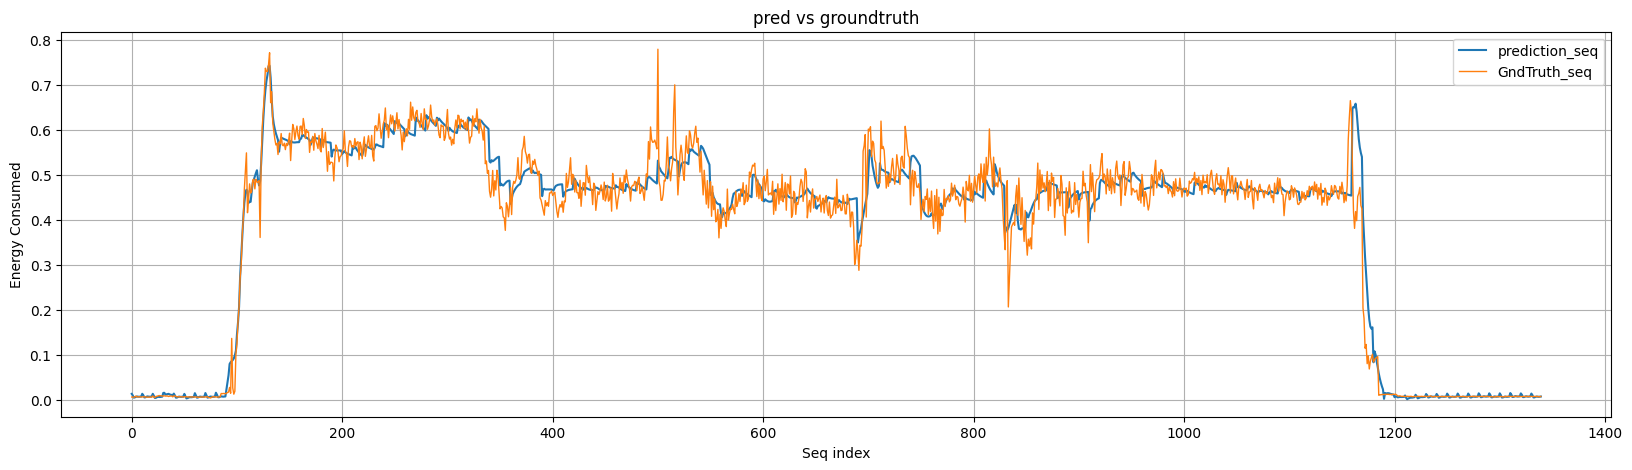

In [12]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
flight_num = 276 #random.randint(0, 100)
flight_num = random.choice(d_split['test'])
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                         test_data['power'].values,input_len,output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [13]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
mape_list = []
flights = d_split['test']
# flights.remove(273)
for flight_num in flights:
    # flight_num = 276 #random.randint(0, 100)
    test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.05)]
    input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values,input_len,output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)


    with torch.no_grad():
        
        outputs = seq2seq(input_seq)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq

        error = nn.MSELoss()(outputs, targets)
        # print(f"Test loss: {error}")

        mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
        # print(f"MAPE: {mape}")
        mape_list.append(mape)
        # plot_output(outputs.cpu(), targets.cpu(), output_len)

print(f"avg MAPE: {sum(mape_list)/len(mape_list)}")


avg MAPE: 8.542445182800293


In [14]:
from data_process import create_sequences
from utils import plot_output
import numpy as np

mape_list = []
for flight_num in flights:
    test_data = data[(data['flight'] == flight_num)]
    outputs = test_data['power'].mean()
    test_data = test_data[data['power'] > 0.05]

    # test_data.plot(x='time', y='power', figsize=(20, 5))

    
    targets = test_data['power'].values
    mape = np.mean(np.abs((outputs - targets) / targets)) * 100
    # print(f"MAPE: {mape}")
    mape_list.append(mape)

print(f"avg worst MAPE: {sum(mape_list)/len(mape_list)}")

avg worst MAPE: 28.041943203441367


In [15]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
test_nums = d_split['test']
sum_mape = 0
sum_size = 0
for f_num in d_split['test']:
    test_data = data[data['flight'] == f_num]
    input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values,input_len,output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

    # print(f"Flight {f_num}:")

    with torch.no_grad():
        
        outputs = seq2seq(input_seq)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq
    
        # error = nn.MSELoss()(outputs, targets)
        # print(f"Test loss: {error}")

        mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
        sum_mape += mape
        sum_size += targets.shape[0]*targets.shape[1]

print(f"Test MAPE: {sum_mape/sum_size}")


Test MAPE: 16.961284637451172


In [16]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_best_model_{input_len}-{output_len}.pt'))

# test the model
seq2seq.eval()
mape_list = []
sum_mape = 0
sum_size = 0
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)
        
    mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
    sum_mape += mape
    sum_size += targets.shape[0]*targets.shape[1]

print(f"Test MAPE: {sum_mape/sum_size}")


Test MAPE: 16.96623420715332


It seems LSTM-LSTM is better than current design of TCN-LSTM